# Statistics for MIND 
[MIND](https://msnews.github.io/)

### Necessary imports / Runs


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from tabulate import tabulate
import dataframe_image as dfi
from tqdm import tqdm
import pickle
import scipy.stats

Set up paths for small and large dataset

In [3]:
# News
path_train_news_small = "Dataset_small/train/news.tsv"
path_train_news_large = "MINDlarge_train.zip/train/news.tsv"

path_val_news_small = "Dataset_small/valid/news.tsv"
path_val_news_large = "MINDlarge_train.zip/valid/news.tsv"

# Behaviors
path_train_behaviors_small = "Dataset_small/train/behaviors.tsv"
path_train_behaviors_large = "MINDlarge_train.zip/train/behaviors.tsv"

path_val_behaviors_small = "Dataset_small/valid/behaviors.tsv"
path_val_behaviors_large = "MINDlarge_train.zip/valid/behaviors.tsv"

Columns of MIND

In [3]:
cols_news = ['News ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]

cols_behaviors = ['Impression ID', 
'User ID',
'Time',
'History' ,
'Impressions']

news_description = [
    'Unique identifier of the news entry',
    'Main topic of the news e.g. sports',
    'Sub topic of the news e.g. soccer',
    'Header shown to the user',
    'Small description of the news',
    'Site link to the news',
    'Key words of the title',
    'Key words of the abstract'
]

behaviors_description = [
    'Unique identifier of the impression',
    'User identified by his unique ID who the impression was shown to',
    'Timestamp when the impression was shown',
    'List of news which were clicked by the user in the past',
    'Choice of news which were shown to the user with concatenated 0 or 1 for not clicked/clicked news'
]

vals_news = [[n,b] for n,b in zip(cols_news,news_description)]

# print("Table of news")
# print(tabulate(vals_news,headers=["Columns","Description"],tablefmt='pretty',showindex=True))

vals_behaviors = [[n,b] for n,b in zip(cols_behaviors,behaviors_description)]

# print("\nTable of behaviors")
# print(tabulate(vals_behaviors,headers=["Columns","Description"],tablefmt='pretty',showindex=True))

In [4]:
small_train_news = pd.read_csv(path_train_news_small,delimiter='\t')
small_train_news.columns = cols_news

small_train_behaviors = pd.read_csv(path_train_behaviors_small,delimiter='\t')
small_train_behaviors.columns = cols_behaviors

small_val_news = pd.read_csv(path_val_news_small,delimiter='\t')
small_val_news.columns = cols_news

small_val_behaviors = pd.read_csv(path_val_behaviors_small,delimiter='\t')
small_val_behaviors.columns = cols_behaviors

large_train_news = pd.read_csv(path_train_news_large,delimiter='\t')
large_train_news.columns = cols_news

large_train_behaviors = pd.read_csv(path_train_behaviors_large,delimiter='\t')
large_train_behaviors.columns = cols_behaviors

### First overview

The MIND dataset consists of two different tabular datasets - a news dataset (*news.tsv*) and a behaviors dataset (*behaviors.tsv*).\
\
Each entry in the news dataset correspond to a different news with an unique 'News ID'.\
Each entry in the behaviors dataset correspond to a different impression with an unique 'Impression ID'. 


<ins>Note:</ins>\
MIND provides three different types of dataset sizes *demo*, *small* and *large*. This work focuses mostly on the *small* dataset. If the *large* dataset is not specifically mentioned the test is made on the *small* set.

In [5]:
df = pd.DataFrame(vals_behaviors,columns=["Columns","Description"])

df2 = pd.DataFrame(vals_news,columns=["Columns","Description"])

pd.set_option("display.max_colwidth", None)
dfStyler1 = df.style.set_properties(**{'text-align': 'left'})
dfStyler1.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
display(dfStyler1)

dfStyler2 = df2.style.set_properties(**{'text-align': 'left'})
dfStyler2.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
display(dfStyler2)

# Export the dataframe
if False:
    dfi.export(dfStyler1,'table_behaviors_description.png')
    dfi.export(dfStyler2,'table_news_description.png')



,Columns,Description
0,Impression ID,Unique identifier of the impression
1,User ID,User identified by his unique ID who the impression was shown to
2,Time,Timestamp when the impression was shown
3,History,List of news which were clicked by the user in the past
4,Impressions,Choice of news which were shown to the user with concatenated 0 or 1 for not clicked/clicked news


,Columns,Description
0,News ID,Unique identifier of the news entry
1,Category,Main topic of the news e.g. sports
2,SubCategory,Sub topic of the news e.g. soccer
3,Title,Header shown to the user
4,Abstract,Small description of the news
5,URL,Site link to the news
6,Title Entities,Key words of the title
7,Abstract Entities,Key words of the abstract


MIND comes with a training and a validation set

In [5]:
train_news_small = pd.read_csv(path_train_news_small,delimiter='\t',names = cols_news)
val_news_small = pd.read_csv(path_val_news_small,delimiter='\t',names = cols_news)

train_news_large = pd.read_csv(path_train_news_large,delimiter='\t',names = cols_news)
val_news_large = pd.read_csv(path_val_news_large,delimiter='\t',names = cols_news)
vals = [
    ['Small train',len(train_news_small)],
    ['Small valid',len(val_news_small)],
    ['Large train',len(train_news_large)],
    ['Large valid',len(val_news_large)]]

print("News: ")
print(tabulate(vals,headers=['Set','Size'],tablefmt='pretty'))


train_behaviors_small = pd.read_csv(path_train_behaviors_small,delimiter='\t',names = cols_behaviors)
val_behaviors_small = pd.read_csv(path_val_behaviors_small,delimiter='\t',names = cols_behaviors)

train_behaviors_large = pd.read_csv(path_train_behaviors_large,delimiter='\t',names = cols_behaviors)
val_behaviors_large = pd.read_csv(path_val_behaviors_large,delimiter='\t',names = cols_behaviors)

vals = [
    ['Small train',len(train_behaviors_small)],
    ['Small valid',len(val_behaviors_small)],
    ['Large train',len(train_behaviors_large)],
    ['Large valid',len(val_behaviors_large)]]

print("Behaviors: ")
print(tabulate(vals,headers=['Set','Size'],tablefmt='pretty'))


News: 
+-------------+--------+
|     Set     |  Size  |
+-------------+--------+
| Small train | 51282  |
| Small valid | 42416  |
| Large train | 101527 |
| Large valid | 72023  |
+-------------+--------+
Behaviors: 
+-------------+---------+
|     Set     |  Size   |
+-------------+---------+
| Small train | 156965  |
| Small valid |  73152  |
| Large train | 2232748 |
| Large valid | 376471  |
+-------------+---------+


Number of different user

In [8]:
len(train_behaviors_small['User ID'].unique())

50000

Print the first entries of the table to get an idea of the data structure

In [6]:
total_small = pd.concat([small_train_behaviors,val_behaviors_small])

In [18]:
len(val_behaviors_small)/len(total_small)

0.3178918458516574

### News statistics
In this section we have a look at the news dataset.\


<ins>Small</ins>

In [7]:
# Save lenght of each title in the data
title_lens_chars = [len(tit) for tit in small_train_news['Title']]

num_bins_chars = len(set(title_lens_chars))
print(f"Number of different title sizes : {num_bins_chars}")

Number of different title sizes : 184


In [8]:
# Save lenght of each title in the data
title_lens_words = [len(tit.split(' ')) for tit in small_train_news['Title']]

num_bins_words = len(set(title_lens_words))
print(f"Number of different title sizes : {num_bins_words}")

Number of different title sizes : 42


<ins>Large</ins>

In [14]:
# Save lenght of each title in the data
title_lens_l = [len(tit) for tit in large_train_news['Title']]

num_bins_l = len(set(title_lens_l))
print(f"Number of different title sizes : {num_bins_l}")

Number of different title sizes : 195


#### Distribution of the title sizes

<ins>Small</ins>

In [9]:
titles_np = np.array(title_lens_chars)

# Mean
tit_mean = titles_np.mean()
# Variance
tit_var = titles_np.var()
# Standard dev.
tit_std = titles_np.std()

print(f"Mean : {tit_mean} Variance : {tit_var} Standard deviation : {tit_std}")

Mean : 66.24716756693512 Variance : 369.28741933833385 Standard deviation : 19.21685248260843


In [112]:
tit_mean - 2 * tit_std

27.813462601718257

In [113]:
tit_mean + 2 * tit_std

104.68087253215198

In [115]:
titles_np = np.array(title_lens_words)

# Mean
tit_mean = titles_np.mean()
# Variance
tit_var = titles_np.var()
# Standard dev.
tit_std = titles_np.std()

print(f"Mean : {tit_mean} Variance : {tit_var} Standard deviation : {tit_std}")

Mean : 10.769914783253057 Variance : 10.801899817234508 Standard deviation : 3.2866243803079334


In [116]:
tit_mean - 2 * tit_std

4.19666602263719

In [117]:
tit_mean + 2 * tit_std

17.343163543868926

Most titles have 4 to 17 words

<ins>Large</ins>

In [15]:
titles_np_l = np.array(title_lens_l)

# Mean
tit_mean = titles_np_l.mean()
# Variance
tit_var = titles_np_l.var()
# Standard dev.
tit_std = titles_np_l.std()

print(f"Mean : {tit_mean} Variance : {tit_var}")

Mean : 66.01484348836752 Variance : 371.77360115500494


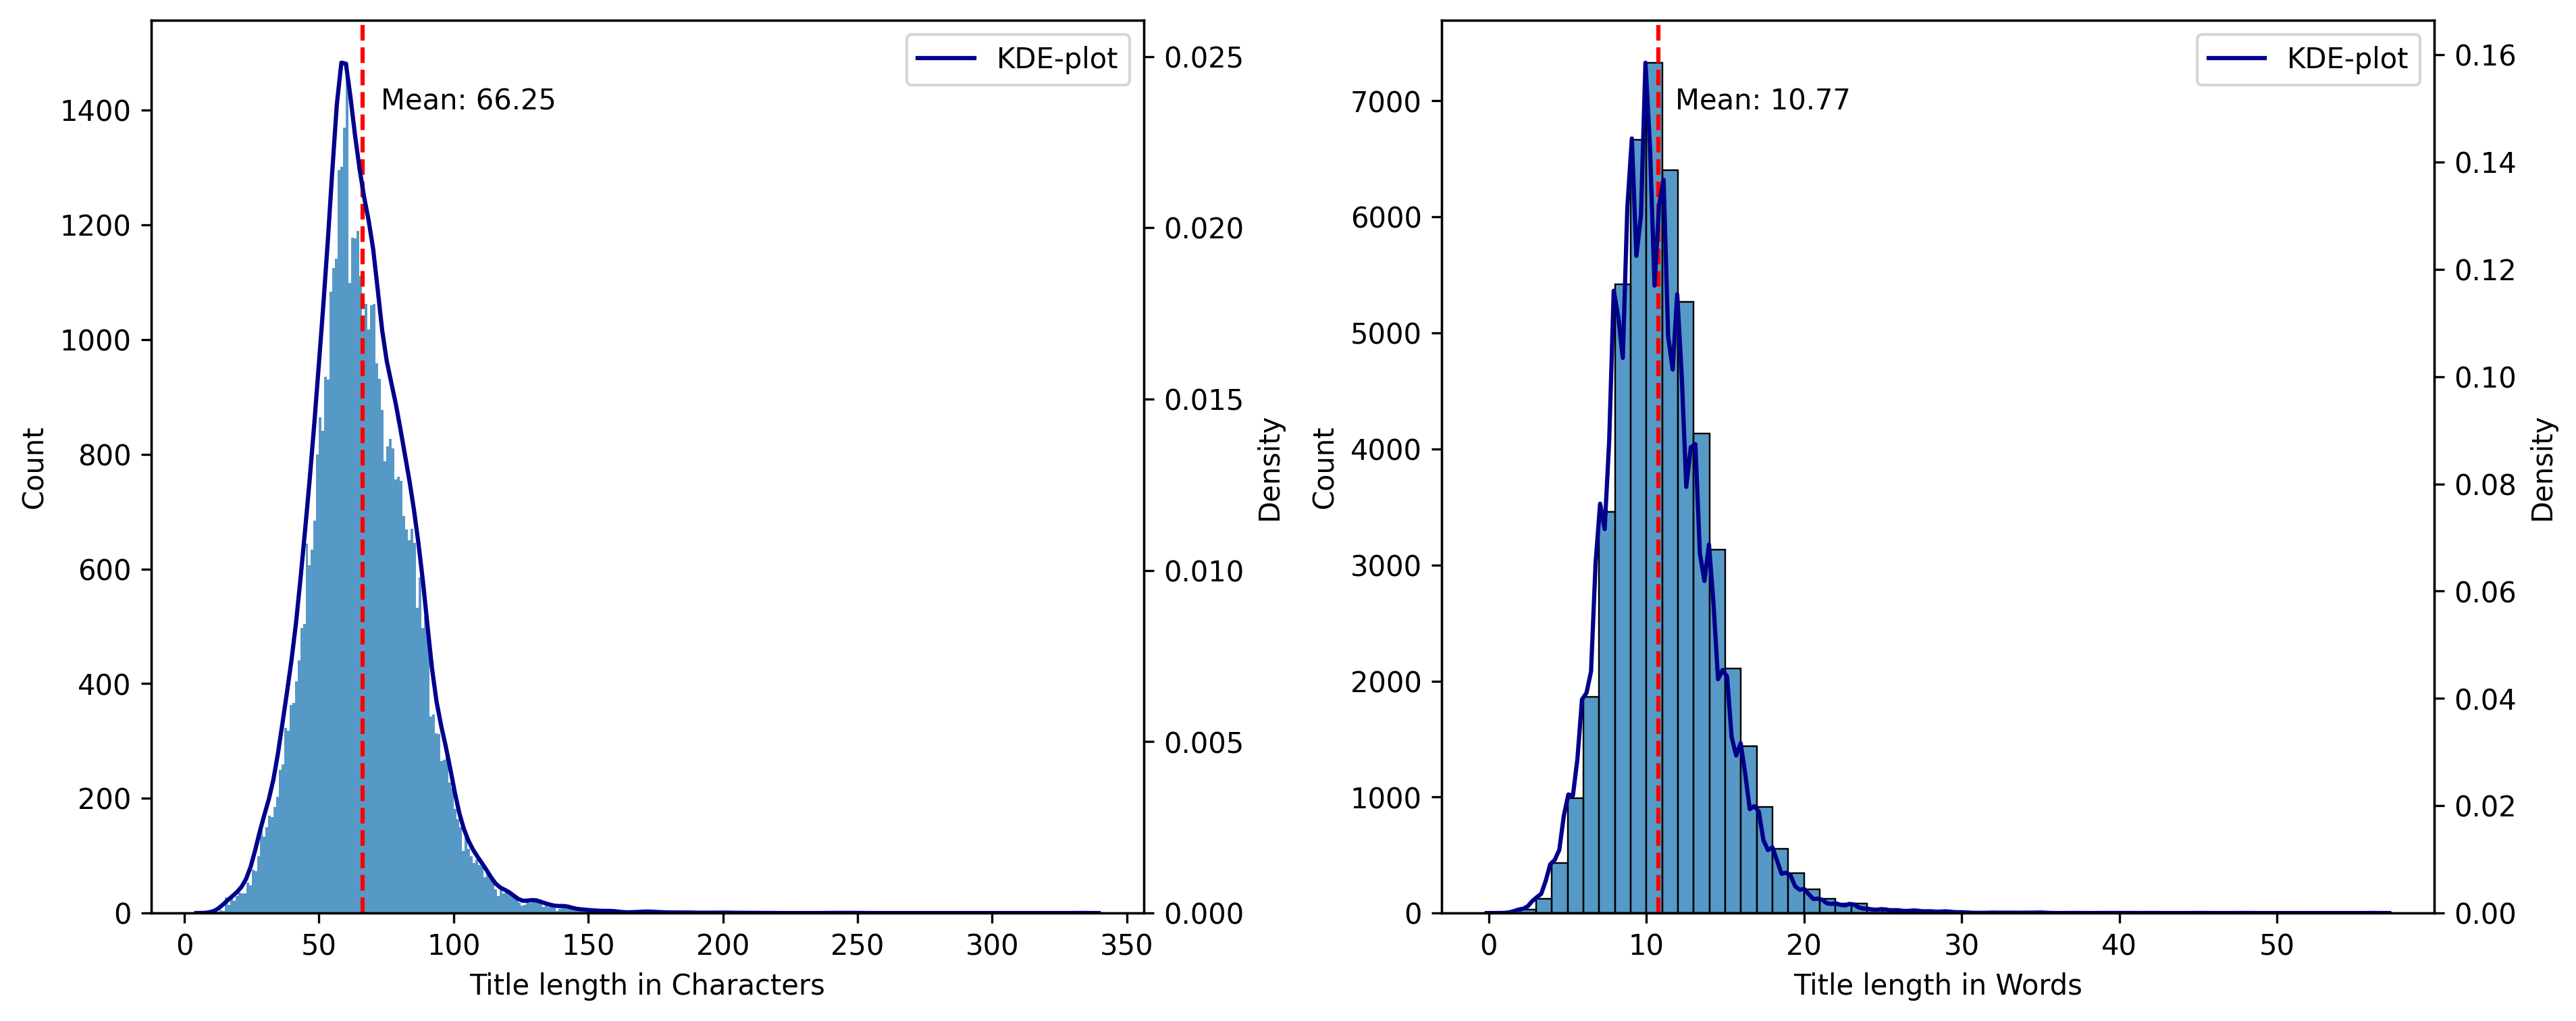

In [80]:
from scipy.stats import norm

fig, (ax_left,ax_right) = plt.subplots(1,2,figsize=(12, 5),dpi=300)

fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
# Histogram
sb.histplot(title_lens_chars,bins=list(set(title_lens_chars)),ax=ax_left,label ="Histogram",edgecolor=(0,0,0,0))
ax_left.set_xlabel("Title length in Characters")


# Mean with text on it is modified by https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
ax_left.axvline(tit_mean,color="red", linestyle='dashed', linewidth=1.5)
_, max_ylim = ax_left.get_ylim()
ax_left.text(tit_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(tit_mean))
ax2= ax_left.twinx()

# KDE plot
sb.kdeplot(title_lens_chars,color="darkblue",ax=ax2,label="KDE-plot")
ax2.legend(loc="upper right")

# Histogram
sb.histplot(title_lens_words,bins=list(set(title_lens_words)),ax=ax_right)
ax_right.set_label("Histogram")

mean_title_lens_words = np.mean(title_lens_words)
_, max_ylim = ax_right.get_ylim()
ax_right.set_xlabel("Title length in Words")
# Mean with text on it is modified by https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
ax_right.axvline(mean_title_lens_words,color="red", linestyle='dashed', linewidth=1.5)
ax_right.text(mean_title_lens_words*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_title_lens_words))
ax3= ax_right.twinx()

# KDE plot
sb.kdeplot(title_lens_words,color="darkblue",ax=ax3,label="KDE-plot")
ax3.legend(loc="upper right")


plt.savefig('histogram_kde_titles.pdf',format='pdf',bbox_inches = "tight")
plt.show()



<Figure size 432x288 with 0 Axes>

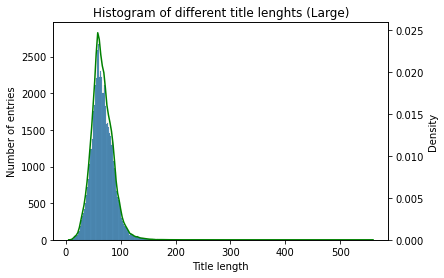

In [36]:
# Histogram
plt.figure(2)
fig2, ax3 = plt.subplots()
plt.title("Histogram of different title lenghts (Large)")
plt.xlabel("Title length")
plt.ylabel("Number of entries")
sb.histplot(title_lens_l,bins=sorted(list(set(title_lens_l))),ax=ax3)

ax4= ax3.twinx()
# KDE plot
plt.xlabel("Title length")
sb.kdeplot(title_lens_l,ax=ax4,color="green")

plt.show()

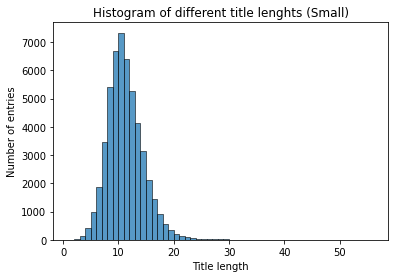

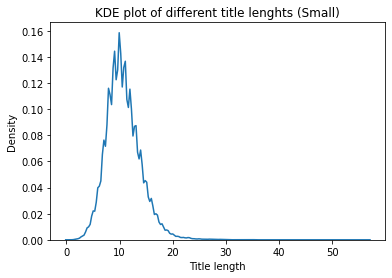

In [18]:
# Histogram
plt.figure(1)
plt.title("Histogram of different title lenghts (Small)")
plt.xlabel("Title length")
plt.ylabel("Number of entries")
sb.histplot(title_lens_words,bins=list(set(title_lens_words)))

# KDE plot
plt.figure(2)
plt.title("KDE plot of different title lenghts (Small)")
plt.xlabel("Title length")
sb.kdeplot(title_lens_words)
plt.show()

Biggest/Smallest titles (in terms of characters)

<ins>Small</ins>

In [13]:
longest_title_id,max_tit = np.argmax(titles_np,0),np.max(titles_np,0)
shortest_title_id,min_tit = np.argmin(titles_np,0),np.min(titles_np,0)

print(f"Longest title with {max_tit} chars: '{small_train_news['Title'][longest_title_id]}'")
print(f"Shortest title with {min_tit} chars: '{small_train_news['Title'][shortest_title_id]}'")

Longest title with 333 chars: 'The Price You Pay: The spiraling cost of college	In our new series, The Price You Pay," we look at the rising cost of attending a public college, which has risen ten-fold since 1965. Tony Dokoupil reports on how amenities at some universities, aimed at attracting more students, are adding to the spiralling cost of higher education.'
Shortest title with 11 chars: 'NBA Dancers'


#### Different categories

<a id='Different_cats'></a>


In [29]:
categories = set(small_train_news['Category'])
print(f"Number of different categories : {len(categories)}")
print(categories)

Number of different categories : 17
{'sports', 'autos', 'kids', 'lifestyle', 'foodanddrink', 'movies', 'travel', 'music', 'middleeast', 'finance', 'weather', 'video', 'health', 'entertainment', 'northamerica', 'tv', 'news'}


How often of each category is present in MIND

{'sports': 14510, 'autos': 1639, 'kids': 17, 'lifestyle': 2478, 'foodanddrink': 2551, 'movies': 606, 'travel': 2350, 'music': 769, 'middleeast': 2, 'finance': 3107, 'weather': 2048, 'video': 2068, 'health': 1885, 'entertainment': 587, 'northamerica': 1, 'tv': 889, 'news': 15774}


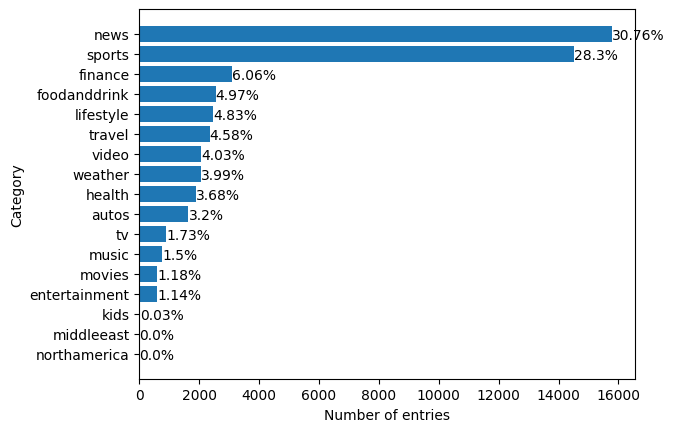

In [36]:
num_in_categories = {}

# Number of entries for each category
for cat in categories:
  num_in_categories[cat] = len(small_train_news.loc[small_train_news['Category'] == cat])



print(num_in_categories)
num_in_categories = {k: v for k, v in sorted(num_in_categories.items(), key=lambda item: item[1])}


plt.rcdefaults()
fig, ax = plt.subplots()

# Initialize bar plot
bars = ax.barh([i for i in range(len(categories))],num_in_categories.values(),tick_label=list(num_in_categories.keys()))

# Add values to the right of the bars
for i, v in enumerate(num_in_categories.values()):
    ax.text(v + 3, i-0.25, f"{str(round(100*v/len(small_train_news),2))}%",
            color = 'black')

plt.xlabel("Number of entries")
plt.ylabel("Category")
plt.savefig('Different_categories.pdf',format='pdf',bbox_inches = "tight")
plt.show()

How many subcategories does each category have

In [25]:
for cat in num_in_categories.keys():
    print(f"{cat} with {len(small_train_news.loc[small_train_news['Category'] == cat]['SubCategory'].unique())} subcategories")

northamerica with 1 subcategories
middleeast with 1 subcategories
kids with 5 subcategories
entertainment with 15 subcategories
movies with 7 subcategories
music with 11 subcategories
tv with 10 subcategories
autos with 24 subcategories
health with 20 subcategories
weather with 2 subcategories
video with 14 subcategories
travel with 14 subcategories
lifestyle with 47 subcategories
foodanddrink with 16 subcategories
finance with 32 subcategories
sports with 31 subcategories
news with 33 subcategories


Top subcategory of each Category

In [34]:
result = {}
for cat in num_in_categories.keys():
    submax = -1
    for sc in small_train_news.loc[small_train_news['Category'] == cat]['SubCategory'].unique():
        len_sub = len(small_train_news.loc[small_train_news['SubCategory'] == sc])
        if submax < len_sub:
            result[cat] = str(sc)
            submax = len_sub

        elif submax == len_sub:
            result[cat] = f"{str(sc)},{sc}"
        
print(result)
    

{'northamerica': 'northamerica-video', 'middleeast': 'middleeast-top-stories', 'kids': 'animals', 'entertainment': 'news', 'movies': 'movienews', 'music': 'musicnews', 'tv': 'tvnews', 'autos': 'autosnews', 'health': 'medical', 'weather': 'weathertopstories', 'video': 'news', 'travel': 'newstrends', 'lifestyle': 'lifestylebuzz', 'foodanddrink': 'newstrends', 'finance': 'financenews', 'sports': 'football_nfl', 'news': 'newsus'}


### Behaviors statistics

Number of impressions

In [121]:
len(small_train_behaviors)

156964

In [16]:
small_train_behaviors.head()

,Impression ID,User ID,Time,History,Impressions
0,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129 N1569 N17686 N13008 N21623 N6233 N14340 N48031 N62285 N44383 N23061 N16290 N6244 N45099 N58715 N59049 N7023 N50528 N42704 N46082 N8275 N15710 N59026 N8429 N30867 N56514 N19709 N31402 N31741 N54889 N9798 N62612 N2663 N16617 N6087 N13231 N63317 N61388 N59359 N51163 N30698 N34567 N54225 N32852 N55833 N64467 N3142 N13912 N29802 N44462 N29948 N4486 N5398 N14761 N47020 N65112 N31699 N37159 N61101 N14761 N3433 N10438 N61355 N21164 N22976 N2511 N48390 N58224 N48742 N35458 N24611 N37509 N21773 N41011 N19041 N25785,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N22407-0 N14592-0 N17059-1 N33677-0 N7821-0 N6890-0
1,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384 N46616 N52500 N33164 N47289 N24233 N62058 N26378 N49475 N18870,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N59685-0 N23814-1 N23446-0 N64174-0 N11817-0 N60550-0 N48225-0 N45509-0 N56711-0 N46821-0 N48017-0 N8015-0 N5364-0 N48722-0 N55555-0 N37348-0 N40109-0 N59495-0 N36226-0 N38779-0 N47346-0 N48875-0 N10960-0 N29739-0 N50872-0 N50592-0 N13131-0 N3839-0 N12330-0 N47098-0 N51570-0
2,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 N29757 N31825 N51891,N35729-0 N33632-0 N49685-1 N27581-0
3,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N60408-0 N61497-0 N47412-0 N41220-0 N1940-0 N724-0 N11363-0 N261-0 N33883-0 N36807-0 N11967-0 N17896-0 N13486-0 N10413-0 N54274-0 N4247-0 N27497-0 N38512-0 N30253-0 N45389-0 N20015-0 N20678-0 N54003-0 N35850-0 N33261-0 N32010-0 N57426-0 N7419-0 N50023-0 N36446-0 N26940-0 N28495-0 N19318-0 N4936-0 N28414-0 N25108-0 N32791-0 N23563-0 N39317-0 N16166-0 N37058-0 N64851-0 N46992-0 N57327-0 N12995-0 N58363-0 N53084-0 N11094-0 N36436-0 N305-0 N58241-0 N33212-0 N6975-0 N58114-0 N3344-0 N25406-0 N4741-0 N33885-0 N20915-0 N44941-0 N57319-0 N36532-0 N61822-0 N20527-0
4,6,U19739,11/11/2019 6:52:13 PM,N39074 N14343 N32607 N32320 N22007 N442 N19001 N24294 N51188 N22772 N51188 N12603 N8275 N19741 N6695 N35820 N30531 N15545 N27529 N62703 N59426 N15414 N54827 N21395 N39941 N10824 N42512 N58521 N62846 N14385 N47020 N2142 N17099 N47020 N11804 N52121,N21119-1 N53696-0 N33619-1 N25722-0 N2869-0


### History

<ins>Small</ins>

In [32]:
df_unique_users = small_train_behaviors.drop_duplicates(subset=['User ID'])
len(df_unique_users)

50000

Histogram for the history sizes

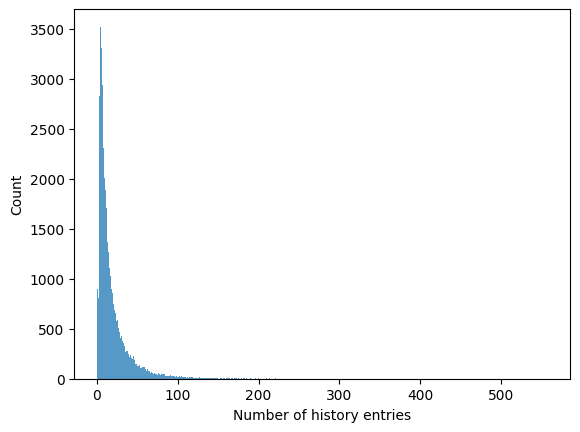

In [81]:
parse_history_lens = [len(v.split(' ')) if v is not np.nan else 0 for v in df_unique_users['History']]

# Draw histogram
sb.histplot(parse_history_lens,bins=sorted(list(set(parse_history_lens))),edgecolor=(0,0,0,0))
plt.xlabel("Number of history entries")
plt.ylabel("Count")

plt.savefig('histogram_history_length.pdf',format='pdf',bbox_inches = "tight")
plt.show()

A textual overview of the distribution

In [129]:
print(f"50% of history sizes are smaller than size {sorted(parse_history_lens)[int(0.5*len(parse_history_lens))]}")
print(f"75% of history sizes are smaller than size {sorted(parse_history_lens)[int(0.75*len(parse_history_lens))]}")
print(f"90% of history sizes are smaller than size {sorted(parse_history_lens)[int(0.9*len(parse_history_lens))]}")
print(f"99% of history sizes are smaller than size {sorted(parse_history_lens)[int(0.99*len(parse_history_lens))]}")

50% of history sizes are smaller than size 11
75% of history sizes are smaller than size 22
90% of history sizes are smaller than size 42
99% of history sizes are smaller than size 116


In [138]:
from collections import Counter

a = {k: v for k, v in sorted(dict(Counter(parse_history_lens)).items(), key=lambda item: item[1],reverse=True)}
a

{4: 3518,
 5: 3310,
 6: 2939,
 3: 2824,
 7: 2679,
 8: 2308,
 9: 2008,
 10: 1889,
 11: 1702,
 2: 1631,
 12: 1563,
 13: 1363,
 14: 1268,
 15: 1108,
 16: 1030,
 17: 967,
 18: 898,
 0: 892,
 19: 853,
 1: 804,
 20: 746,
 21: 690,
 22: 659,
 23: 634,
 25: 583,
 24: 575,
 26: 506,
 27: 471,
 30: 423,
 28: 420,
 29: 411,
 31: 377,
 32: 358,
 34: 332,
 33: 320,
 36: 275,
 37: 273,
 35: 266,
 39: 248,
 41: 242,
 45: 230,
 38: 228,
 40: 218,
 42: 205,
 43: 195,
 46: 188,
 44: 174,
 47: 151,
 48: 147,
 52: 136,
 49: 135,
 51: 132,
 50: 130,
 57: 121,
 58: 119,
 54: 116,
 56: 116,
 53: 107,
 55: 105,
 62: 96,
 60: 93,
 63: 82,
 59: 80,
 61: 79,
 65: 77,
 64: 71,
 70: 68,
 67: 65,
 71: 61,
 76: 58,
 68: 56,
 66: 55,
 77: 50,
 72: 49,
 69: 48,
 83: 46,
 75: 46,
 81: 45,
 73: 45,
 79: 44,
 82: 43,
 74: 41,
 85: 39,
 91: 34,
 78: 33,
 101: 33,
 80: 33,
 84: 32,
 88: 31,
 86: 30,
 89: 30,
 87: 29,
 92: 27,
 94: 26,
 98: 25,
 95: 25,
 93: 24,
 102: 23,
 96: 23,
 104: 23,
 99: 22,
 105: 22,
 90: 21,
 97: 

In [140]:
parse_history_lens = np.array(parse_history_lens)

print(f"Mean: {parse_history_lens.mean()} Median: {np.median(parse_history_lens)} Std: {parse_history_lens.std()}")

Mean: 18.52116 Variance: 11.0 Std: 23.900440001271942


<ins>Large</ins>

In [144]:
df_unique_users_l = large_train_behaviors.drop_duplicates(subset=['User ID'])
len(df_unique_users_l)

711222

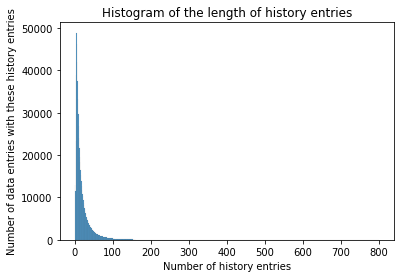

In [143]:
parse_history_lens_l = [len(v.split(' ')) if v is not np.nan else 0 for v in df_unique_users_l['History']]

# Draw histogram
sb.histplot(parse_history_lens_l,bins=sorted(list(set(parse_history_lens_l))))
plt.title("Histogram of the length of history entries")
plt.xlabel("Number of history entries")
plt.ylabel("Number of data entries with these history entries")
plt.show()

In [145]:
print(f"50% of history sizes are smaller than size {sorted(parse_history_lens_l)[int(0.5*len(parse_history_lens_l))]}")
print(f"75% of history sizes are smaller than size {sorted(parse_history_lens_l)[int(0.75*len(parse_history_lens_l))]}")
print(f"90% of history sizes are smaller than size {sorted(parse_history_lens_l)[int(0.9*len(parse_history_lens_l))]}")
print(f"99% of history sizes are smaller than size {sorted(parse_history_lens_l)[int(0.99*len(parse_history_lens_l))]}")

50% of history sizes are smaller than size 11
75% of history sizes are smaller than size 22
90% of history sizes are smaller than size 43
99% of history sizes are smaller than size 119


### Candidates (Impressions)

Candidates are the news which are shown in the impression. A clicked candidate is indicated by a '1'. Non-clicked candidates are indicated by a '0'.

In [20]:
# Calculate the number of candidates per impression
impression_sizes = [len(imp.split(' ')) for imp in small_train_behaviors['Impressions']]
num_of_candidates = []
for imp in small_train_behaviors['Impressions']: # Note that impressions are in the form of "imprID_1-0 imprID_2-1 imprID_3-0 ..."
    counter = 0
    for s in imp.split(' '):
        if s.split('-')[1] == '1':  
            counter += 1
    num_of_candidates.append(counter)

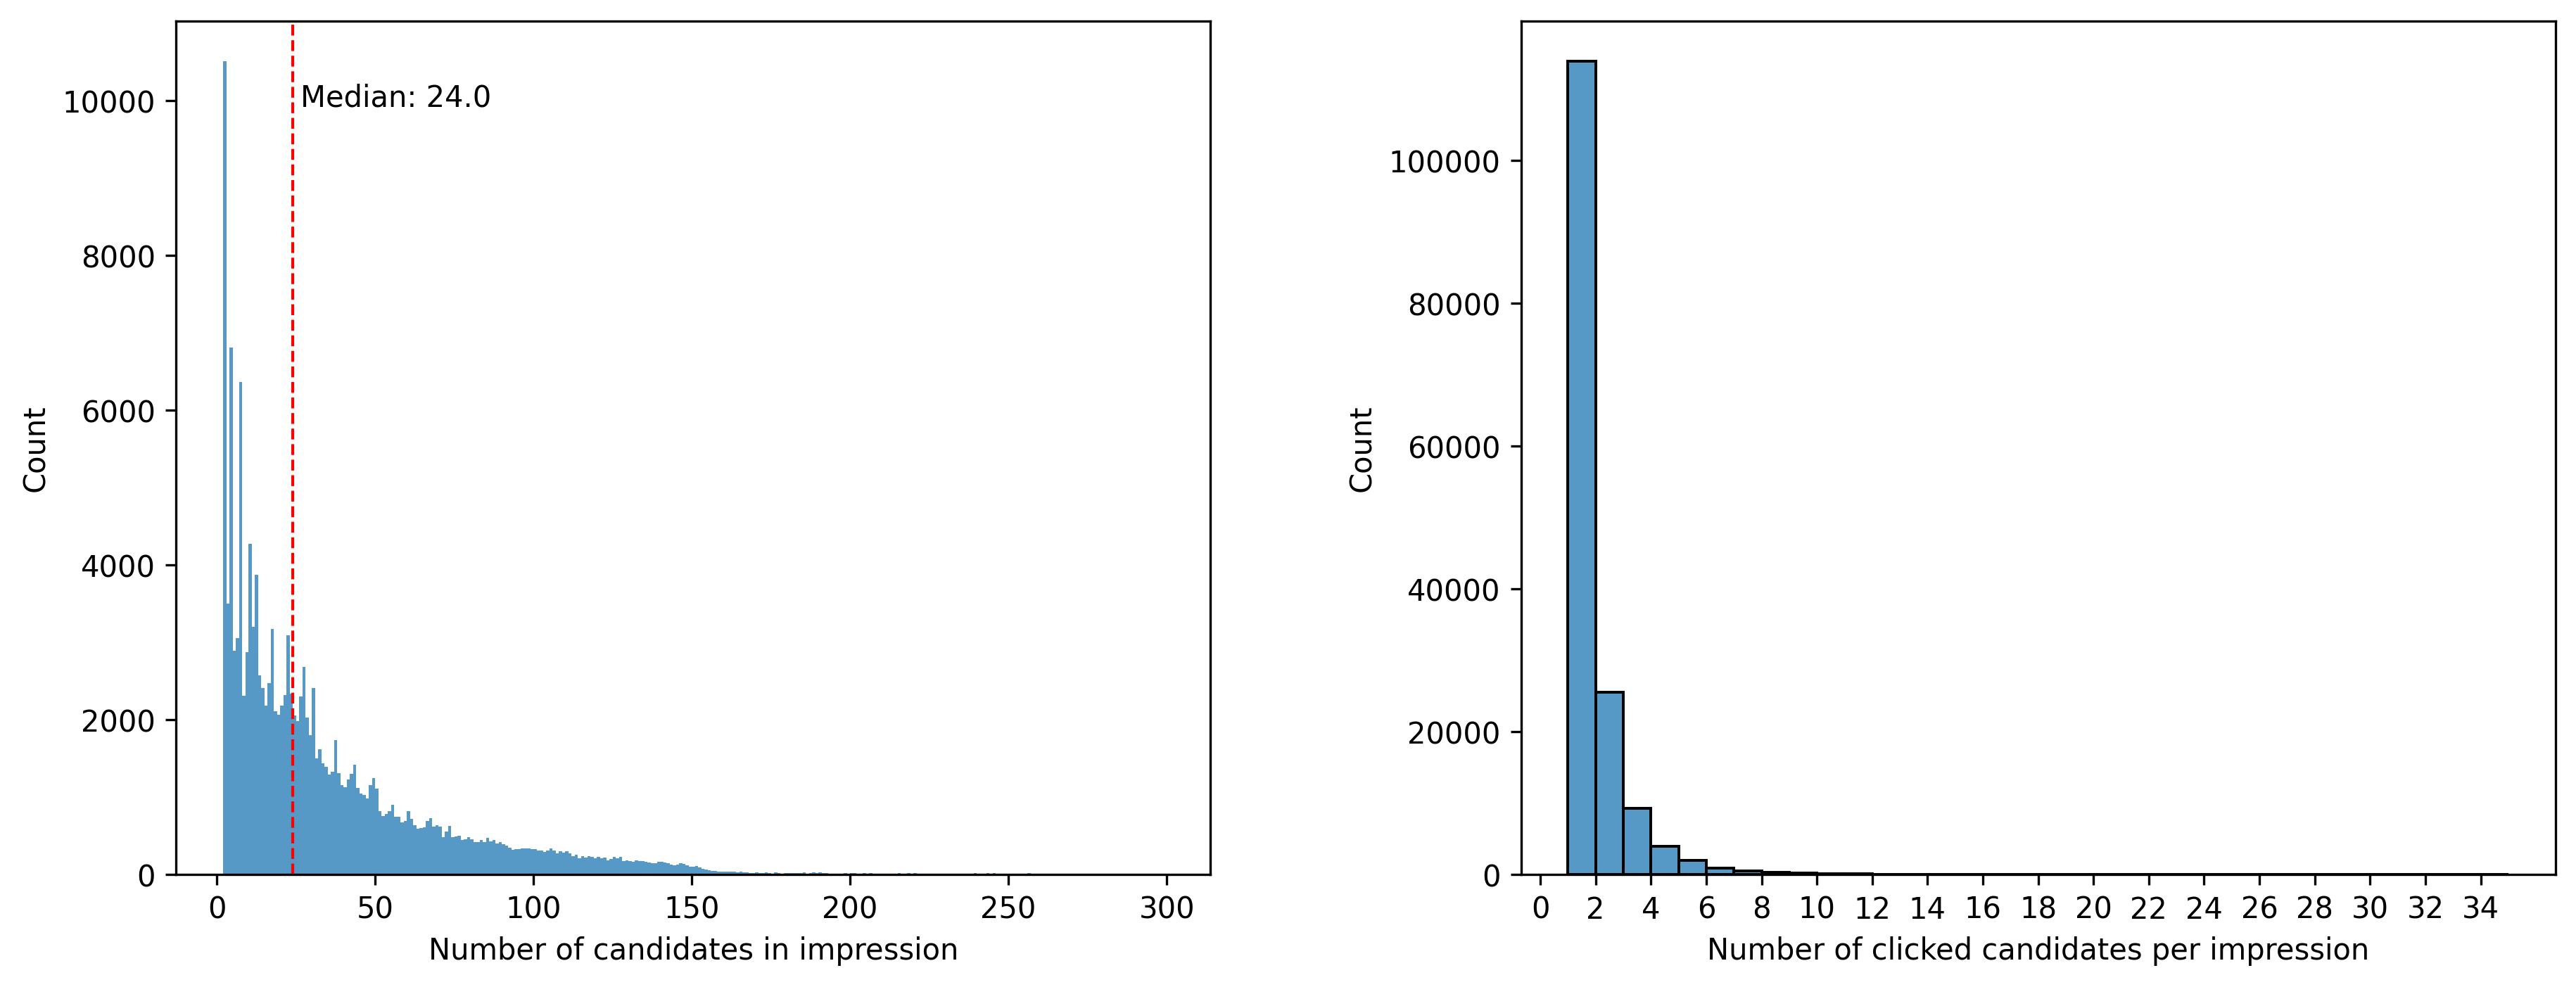

In [37]:
fig, (ax_left,ax_right) = plt.subplots(1,2,figsize=(12, 5),dpi=300)
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)


fig.subplots_adjust(wspace=0.3)
# Left graph : Number of different sizes of impressions
ax_left.set_xlabel("Number of candidates in impression")
sb.histplot(impression_sizes,bins=sorted(list(set(impression_sizes))),ax=ax_left,edgecolor=(0,0,0,0))

# Add median line 
median_imp_size = np.median(impression_sizes)
ax_left.axvline(median_imp_size,color="red", linestyle='dashed', linewidth=1)
_, max_ylim = ax_left.get_ylim()
ax_left.text(median_imp_size*1.1, max_ylim*0.9, f'Median: {median_imp_size}')




# Right graph : Number of clicked candidates per impression
ax_right.set_xlabel("Number of clicked candidates per impression")
ax_right.set_xticks(range(0,36,2))
sb.histplot(num_of_candidates,bins=sorted(list(set(num_of_candidates))),ax=ax_right)


plt.savefig('candidates_histograms.pdf',format='pdf',bbox_inches = "tight")
plt.show()

In [50]:
sorted(np_impression_sizes,reverse=True)[:5]

[299, 297, 295, 295, 294]

In [31]:
np_impression_sizes = np.array(impression_sizes)
np_num_of_candidates = np.array(num_of_candidates)


print(f"Average click ratio on impressions: {np.mean(np_num_of_candidates/np_impression_sizes)}")

print(f"Median of the {np.median(np_impression_sizes)}")

Average click ratio on impressions: 0.10854170405379965
Median of the 24.0


Histogram for the number of clicked candidates

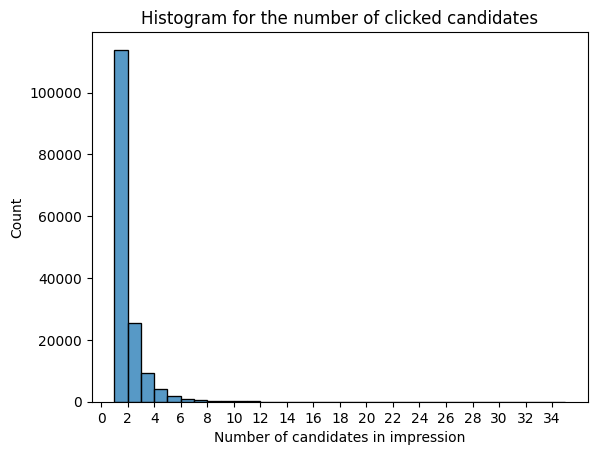

In [24]:
plt.xlabel("Number of candidates in impression")
plt.xticks(range(0,36,2))
sb.histplot(num_of_candidates,bins=sorted(list(set(num_of_candidates))))
plt.savefig('number_of_clicked_candidates.pdf',format='pdf',bbox_inches = "tight")
plt.show()

Visualization in percentage

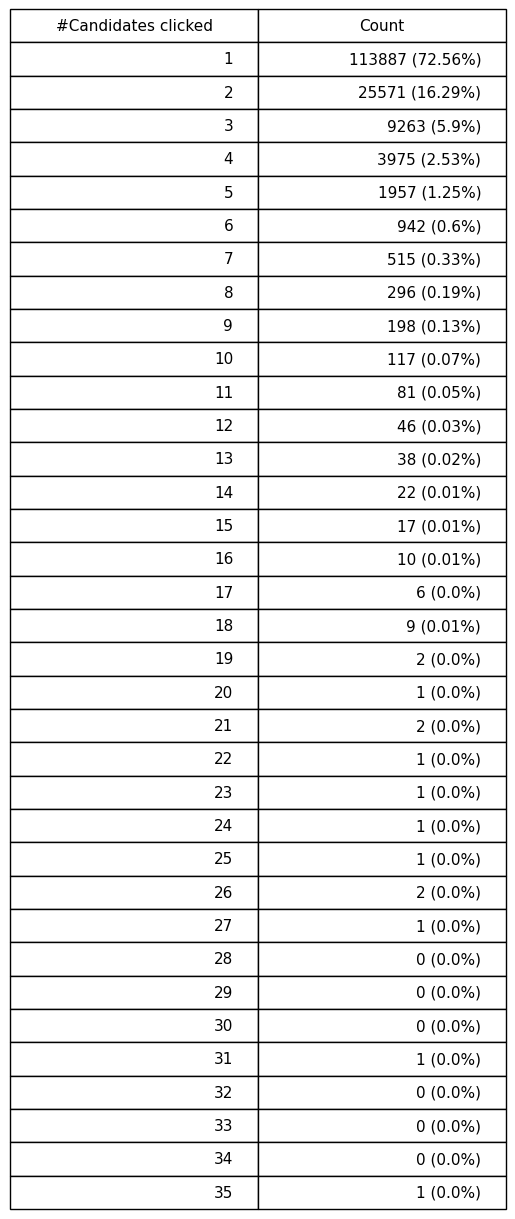

In [25]:
tot = len(num_of_candidates)
table_data = []
for i in range(1,max(num_of_candidates)+1):
    num = len([c for c in num_of_candidates if c == i])
    # print(f'Number of impression with {i} candidates: {num} ({round((num/tot)*100,2)}%)')
    table_data.append([i,f"{num} ({round((num/tot)*100,2)}%)"])

fig, ax = plt.subplots()

table = ax.table(cellText=table_data,loc="center",colLabels=["#Candidates clicked","Count"])
table.set_fontsize(11)
table.scale(1,2)
ax.axis('off')
plt.show()

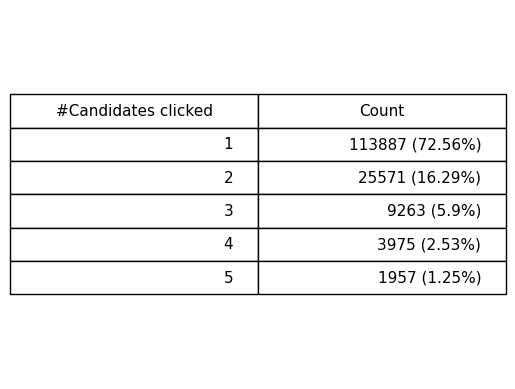

In [38]:
tot = len(num_of_candidates)
table_data = []
for i in range(1,max(num_of_candidates)+1):
    num = len([c for c in num_of_candidates if c == i])
    # print(f'Number of impression with {i} candidates: {num} ({round((num/tot)*100,2)}%)')
    table_data.append([i,f"{num} ({round((num/tot)*100,2)}%)"])

fig, ax = plt.subplots()

table = ax.table(cellText=table_data[:5],loc="center",colLabels=["#Candidates clicked","Count"])
table.set_fontsize(11)
table.scale(1,2)
ax.axis('off')
plt.savefig('tabular_number_candidates_top5.pdf',format='pdf',bbox_inches = "tight")
plt.show()

# Investigating Data biases


Here I take a look at potential data biases

## Popularity bias

Are some news suggested as candidates more often than others?

In [49]:
# Count the news in impressions
small_train_behaviors['Impressions'].iloc[0].split(' ')

news_count = {}

for i in range(len(small_train_behaviors)):
    impr = small_train_behaviors['Impressions'].iloc[i].split(' ')
    for j in range(len(impr)):
        news_id = impr[j].split('-')[0]
        if not news_id in news_count:
            news_count[news_id] = 1
        else:
            news_count[news_id] += 1



Sort results by counts

In [50]:
sorted_results = dict(sorted(news_count.items(), key=lambda item: item[1],reverse=True))
sorted_results_ascending = dict(sorted(news_count.items(), key=lambda item: item[1]))

In [51]:
# Count the news in histories
news_count_history = {}

dropped_nan = small_train_behaviors.dropna(subset=['History'])
for i in range(len(dropped_nan)):
    impr = dropped_nan['History'].iloc[i].split(' ')
    for j in range(len(impr)):
        news_id = impr[j]
        if not news_id in news_count_history.keys():
            news_count_history[news_id] = 1
        else:
            news_count_history[news_id] += 1


In [52]:
sorted_results_hist = dict(sorted(news_count_history.items(), key=lambda item: item[1],reverse=True))
sorted_results_ascending_hist = dict(sorted(news_count.items(), key=lambda item: item[1]))

In [53]:
print(f"{len(news_count)} different news are shown in the impression overall (New news per impression - Ration : {round(len(news_count)/len(small_train_behaviors),2)})")

20288 different news are shown in the impression overall (New news per impression - Ration : 0.13)


In [13]:
sum_counts = 0
for i in range(10):
    a = list(news_count.values()).count(i)
    print(a)
    sum_counts += a
print(f"Sum {sum_counts}")

0
3228
2120
1520
1159
931
809
643
596
465
Sum 11471


In [14]:
11471/20288

0.5654081230283912

In [55]:
# Coded used from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left",fontsize=7)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

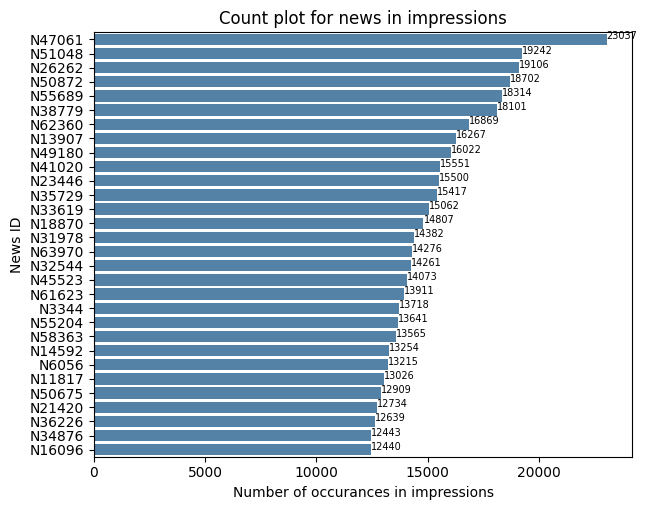

In [59]:
# plt.barh(list(sorted_results.keys())[:30][::-1], list(sorted_results.values())[:30][::-1], color='green')

bars = sb.barplot(x=list(sorted_results.values())[:30],y=list(sorted_results.keys())[:30],color='steelblue',orient='h')

show_values(bars, "h", space=0)

plt.tight_layout()
plt.title("Count plot for news in impressions")
plt.xlabel("Number of occurances in impressions")
plt.ylabel("News ID")

plt.savefig('barplot_most_clicked_imp_news.pdf',format='pdf',bbox_inches = "tight")
plt.show()


# Initialize bar plot
# bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=vals_nocfp)

# plt.title("Histogram: Number of clicks per position")
# plt.xlabel("Position in Impression")
# plt.ylabel("Number of clicks")
# plt.bar_label(bars.containers[0],rotation=90,label_type="center")
# plt.xticks([i for i in range(len(keys_nocfp))],rotation=90)



In [9]:
top_100_categories = {}

for i,k in enumerate(sorted_results.keys()):
    if i == 100:
        break
    cat = small_train_news[small_train_news['News ID'] == k]['Category'].item()
    if not cat in top_100_categories.keys():
        top_100_categories[cat] = 1
    else:
        top_100_categories[cat] += 1

In [10]:
top_100_categories_sorted = dict(sorted(top_100_categories.items(), key=lambda item: item[1],reverse=True))
top_100_categories_sorted

{'news': 20,
 'entertainment': 18,
 'lifestyle': 17,
 'finance': 8,
 'music': 6,
 'tv': 6,
 'sports': 5,
 'travel': 5,
 'autos': 4,
 'weather': 3,
 'health': 3,
 'foodanddrink': 2,
 'movies': 2,
 'video': 1}

In [11]:
top_100_categories_hist = {}

for i,k in enumerate(sorted_results_hist.keys()):
    if i == 100:
        break
    cat = small_train_news[small_train_news['News ID'] == k]['Category'].item()
    if not cat in top_100_categories_hist.keys():
        top_100_categories_hist[cat] = 1
    else:
        top_100_categories_hist[cat] += 1

In [12]:
top_100_categories_sorted_hist = dict(sorted(top_100_categories_hist.items(), key=lambda item: item[1],reverse=True))
top_100_categories_sorted_hist

{'news': 38,
 'tv': 13,
 'lifestyle': 10,
 'sports': 8,
 'finance': 8,
 'movies': 4,
 'foodanddrink': 4,
 'autos': 3,
 'video': 3,
 'weather': 2,
 'entertainment': 2,
 'travel': 2,
 'music': 2,
 'health': 1}

In [32]:
print(f"{len(news_count_history)} different news are shown in the impression overall (New news per impression - Ration : {round(len(news_count_history)/len(dropped_nan),2)})")

33195 different news are shown in the impression overall (New news per impression - Ration : 0.22)


In [41]:
small_train_news[small_train_news['News ID']  == 'N45794']

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
21465,N45794,news,newscrime,Four flight attendants were arrested in Miami'...,Four American Airlines flight attendants were ...,https://assets.msn.com/labs/mind/AAJcQKF.html,[],"[{""Label"": ""Miami International Airport"", ""Typ..."


In [33]:
sorted_results_hist = dict(sorted(news_count_history.items(), key=lambda item: item[1],reverse=True))
sorted_results_ascending_hist = dict(sorted(news_count_history.items(), key=lambda item: item[1]))

In [43]:
sorted_results_hist['N51048']

KeyError: 'N51048'

#### The most shown news
Have a look at the top 5 most shown news

In [14]:
for j,k in enumerate(sorted_results):
    if j < 5:
        print(f"News title:  {small_train_news[small_train_news['News ID'] == k]['Title'].item()} in {small_train_news[small_train_news['News ID'] == k]['Category'].item()}({small_train_news[small_train_news['News ID'] == k]['SubCategory'].item()}) has been shown in {sorted_results[k]} Impressions (Ration of shown to all impressions : {round(sorted_results[k]/len(small_train_behaviors)*100,3)}%)")

News title:  105 Black Friday Deals You Can Start Shopping Today in lifestyle(shop-holidays) has been shown in 23037 Impressions (Ration of shown to all impressions : 14.677%)
News title:  Rep. Tim Ryan endorses Biden in Democratic primary in news(elections-2020-us) has been shown in 19242 Impressions (Ration of shown to all impressions : 12.259%)
News title:  Celebrity plastic surgery transformations in entertainment(entertainment-celebrity) has been shown in 19106 Impressions (Ration of shown to all impressions : 12.172%)
News title:  50 amazing gifts for every type of person and budget in lifestyle(shop-holidays) has been shown in 18702 Impressions (Ration of shown to all impressions : 11.915%)
News title:  Charles Rogers, former Michigan State football, Detroit Lions star, dead at 38 in sports(football_nfl) has been shown in 18314 Impressions (Ration of shown to all impressions : 11.668%)


In [31]:
for j,k in enumerate(sorted_results):
    if j < 5:
        print(small_train_news[['News ID','URL','Category','Title']].loc[small_train_news['News ID'] == k])

      News ID                                            URL   Category  \
31220  N47061  https://assets.msn.com/labs/mind/BBFu2Vk.html  lifestyle   

                                                     Title  
31220  105 Black Friday Deals You Can Start Shopping Today  
      News ID                                            URL Category  \
41882  N51048  https://assets.msn.com/labs/mind/BBWHmVm.html     news   

                                                    Title  
41882  Rep. Tim Ryan endorses Biden in Democratic primary  
      News ID                                            URL       Category  \
31747  N26262  https://assets.msn.com/labs/mind/BBVcWey.html  entertainment   

                                           Title  
31747  Celebrity plastic surgery transformations  
     News ID                                            URL   Category  \
5117  N50872  https://assets.msn.com/labs/mind/AAJQMdO.html  lifestyle   

                                                  

#### Less shown news


In [32]:
for j,k in enumerate(sorted_results_ascending):
    if j < 5:
        print(f"News {k} has been shown in {sorted_results_ascending[k]} Impressions (Ration of shown to all impressions : {round(sorted_results_ascending[k]/len(small_train_behaviors)*100,3)}%)")

News N32126 has been shown in 1 Impressions (Ration of shown to all impressions : 0.001%)
News N48752 has been shown in 1 Impressions (Ration of shown to all impressions : 0.001%)
News N38057 has been shown in 1 Impressions (Ration of shown to all impressions : 0.001%)
News N29386 has been shown in 1 Impressions (Ration of shown to all impressions : 0.001%)
News N13267 has been shown in 1 Impressions (Ration of shown to all impressions : 0.001%)


In [33]:
for j,k in enumerate(sorted_results):
    if j < 5:
        print(small_train_news[['News ID','URL','Category','Title']].loc[small_train_news['News ID'] == k])

      News ID                                            URL   Category  \
31220  N47061  https://assets.msn.com/labs/mind/BBFu2Vk.html  lifestyle   

                                                     Title  
31220  105 Black Friday Deals You Can Start Shopping Today  
      News ID                                            URL Category  \
41882  N51048  https://assets.msn.com/labs/mind/BBWHmVm.html     news   

                                                    Title  
41882  Rep. Tim Ryan endorses Biden in Democratic primary  
      News ID                                            URL       Category  \
31747  N26262  https://assets.msn.com/labs/mind/BBVcWey.html  entertainment   

                                           Title  
31747  Celebrity plastic surgery transformations  
     News ID                                            URL   Category  \
5117  N50872  https://assets.msn.com/labs/mind/AAJQMdO.html  lifestyle   

                                                  

<AxesSubplot:>

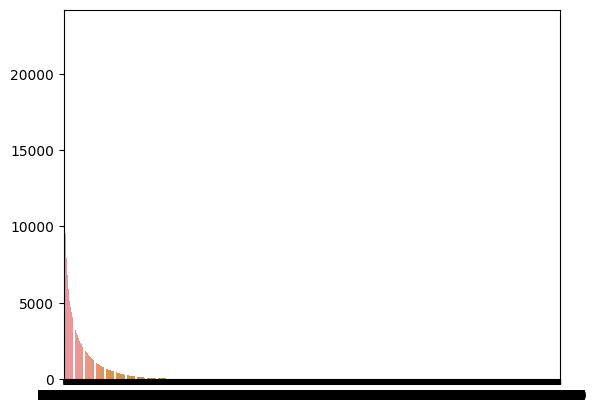

In [34]:
keys = list(sorted_results.keys())
# get values in the same order as keys, and parse percentage values
vals = list(sorted_results.values())
sb.barplot(x=keys, y=vals)


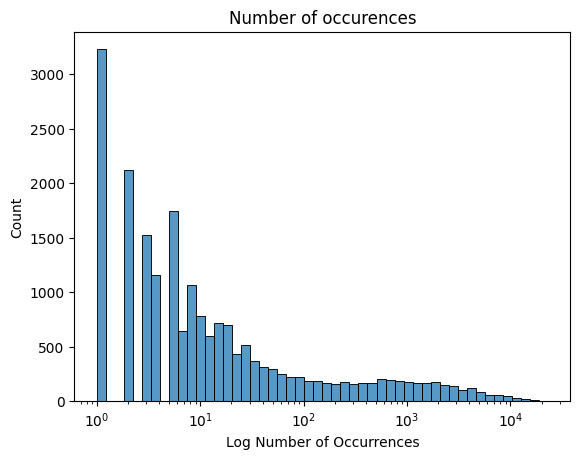

In [35]:
plt.xlabel('Log Number of Occurrences')
plt.title('Number of occurences')
y = sb.histplot(sorted_results,log_scale=True)
plt.show()

In [37]:
# plt.xlabel('Log Number of Occurrences')
# plt.title('Number of occurences')
# y = sb.barplot(sorted_results.items())
# plt.show()

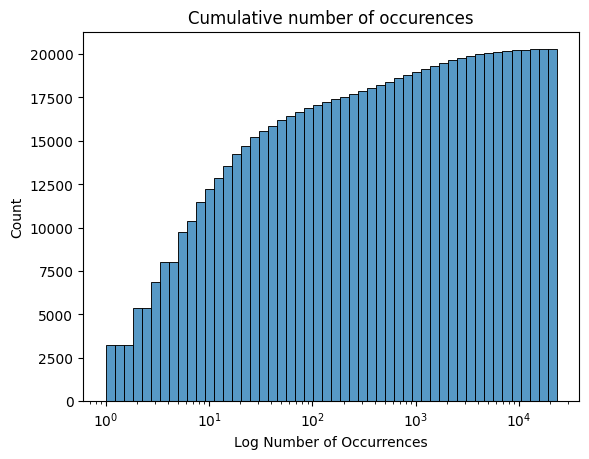

In [38]:
plt.xlabel('Log Number of Occurrences')
plt.title('Cumulative number of occurences')
sb.histplot(sorted_results,log_scale=True,cumulative=True)
plt.show()

## Representational bias / Selection bias

There are two sides of something is under/over represented, on data side and on model side. On data site it is considered as selection bias due to skewness when the data was collected. On model side it is representational bias since data distribution might be amplified by the recommendation model.

### Data sided representational bias

We have already seen in the statistics part that the representation of certain categories are larger than others. To see a trend in more liked categories, I quantify the percentage of each liked item in the categories. 

In [ ]:
categories = set(small_train_news['Category']) # Each category in the dataset


# TODO Zähle die Vorkommnisse der News Categorien und der Clicked News Categorien

category_count = {}
for cat in categories:
    category_count[cat] = len(small_train_news.loc[small_train_news['Category'] == cat])




In [18]:
# This cell calculates the counts of shown and clicked categories and save it into a dictionary
# !This take a while. The dictionaries may be saved and can be loaded in the next cell!
if False:
    category_count_shown = {}
    category_count_clicked = {}
    for cat in categories:
        category_count_shown[cat] = 0
        category_count_clicked[cat] = 0

    for impr in small_train_behaviors['Impressions'][:5].to_dict().values():
        splitted = impr.split(' ')
        for s in splitted:
            news = s.split('-')
            category_count_shown[small_train_news[small_train_news['News ID'] == news[0]]['Category'].item()] += 1
            category_count_clicked[small_train_news[small_train_news['News ID'] == news[0]]['Category'].item()] += int(news[1])


In [14]:
# Save results
if False:
    with open('Snapshots/category_count_shown.pkl', 'wb') as f:
        pickle.dump(category_count_shown, f)
    with open('Snapshots/category_count_clicked.pkl', 'wb') as f:
        pickle.dump(category_count_clicked, f)
# Load results
if True:
    with open('Snapshots/category_count_shown.pkl', 'rb') as f:
        category_count_shown = pickle.load(f)
    with open('Snapshots/category_count_clicked.pkl', 'rb') as f:
        category_count_clicked = pickle.load(f)

In [20]:
total_shown = np.sum(list(category_count_shown.values()))
total_clicked = np.sum(list(category_count_clicked.values()))

for cat in categories:

    print(f"{cat}: Click-Show ratio: {round(category_count_clicked[cat]/(category_count_shown[cat]+1),6)}")
    print(f"{cat} - Clicked percentage: {round(100 * category_count_clicked[cat]/total_clicked,3)}%")
    print(f"{cat} - Shown percentage: {round(100 * category_count_shown[cat]/total_shown,3)}%")

autos: Click-Show ratio: 0.027366
autos - Clicked percentage: 3.143%
autos - Shown percentage: 4.645%
tv: Click-Show ratio: 0.059011
tv - Clicked percentage: 6.154%
tv - Shown percentage: 4.218%
lifestyle: Click-Show ratio: 0.040559
lifestyle - Clicked percentage: 11.248%
lifestyle - Shown percentage: 11.217%
video: Click-Show ratio: 0.045464
video - Clicked percentage: 1.803%
video - Shown percentage: 1.604%
northamerica: Click-Show ratio: 0.033333
northamerica - Clicked percentage: 0.0%
northamerica - Shown percentage: 0.0%
finance: Click-Show ratio: 0.036476
finance - Clicked percentage: 8.715%
finance - Shown percentage: 9.663%
music: Click-Show ratio: 0.059433
music - Clicked percentage: 6.765%
music - Shown percentage: 4.604%
foodanddrink: Click-Show ratio: 0.029463
foodanddrink - Clicked percentage: 4.605%
foodanddrink - Shown percentage: 6.321%
travel: Click-Show ratio: 0.026353
travel - Clicked percentage: 3.514%
travel - Shown percentage: 5.392%
sports: Click-Show ratio: 0.04

Take a look at the distribution of categories in the user histories

In [ ]:
if False:
    def hist_to_cat_count(row):
        if row['History'] is not np.nan:
            hist = row['History'].split(' ')
        else:
            return
        for entry in hist:
            row[small_val_news[small_val_news['News ID'] == entry]['Category']] += 1

    for cat in categories:
            df_hist_cats[cat] = 0
    with tqdm(total=len(df_hist_cats)) as pbar:
        for row in df_hist_cats.iterrows():
            hist_to_cat_count(row[1])
            pbar.update(1)


In [5]:
cats_from_hists= pd.read_csv("Snapshots/hist_to_cats.tsv",sep="\t")

In [12]:
small_val_news[small_val_news['News ID'] == "N56253" ]

,News ID,Category,SubCategory,Title,Abstract,URL,Title Entities,Abstract Entities
16844,N56253,sports,football_nfl,"NFL winners, losers: Cowboys need to rebound, ...",While the Dallas Cowboys need to get back on t...,https://assets.msn.com/labs/mind/AAIKEF3.html,"[{""Label"": ""National Football League"", ""Type"":...","[{""Label"": ""Dallas Cowboys"", ""Type"": ""O"", ""Wik..."


In [16]:
small_train_news[small_train_news['News ID'] == "N22353"]['Category'].item()

'lifestyle'

In [55]:
for idx in range(len(cats_from_hists['Impression ID'])):
    row = cats_from_hists.loc[idx]
    if row['History'] is not np.nan:
        hist = row['History'].split(' ')
    for entry in hist:
        cats_from_hists.loc[idx,[small_val_news[small_val_news['News ID'] == entry]['Category'].item()]] += 1
        print(cats_from_hists.loc[idx,[small_val_news[small_val_news['News ID'] == entry]['Category'].item()]])
        


news    5
Name: 0, dtype: object
travel    2
Name: 0, dtype: object
finance    5
Name: 0, dtype: object
news    6
Name: 0, dtype: object
news    7
Name: 0, dtype: object
finance    6
Name: 0, dtype: object
music    2
Name: 0, dtype: object
news    8
Name: 0, dtype: object
finance    7
Name: 0, dtype: object
weather    2
Name: 0, dtype: object
finance    8
Name: 0, dtype: object
health    2
Name: 0, dtype: object
lifestyle    2
Name: 0, dtype: object


In [59]:
cats_from_hists.loc[410:415]

,Unnamed: 0,Impression ID,User ID,Time,History,Impressions,kids,movies,news,video,...,middleeast,sports,tv,lifestyle,music,finance,foodanddrink,entertainment,health,games
410,410,412,U29201,11/15/2019 2:09:29 PM,N30344 N56253 N23488 N23488 N47558 N64777 N551...,N55237-0 N29091-0 N62365-0 N11930-0 N34130-0 N...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411,411,413,U73687,11/15/2019 8:42:10 AM,N719 N24721 N29523 N63429 N56240 N10414 N11005...,N20036-0 N42844-0 N53697-1 N23535-0 N60939-0 N...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
412,413,415,U517,11/15/2019 2:35:38 PM,N35009 N24148 N16233 N21132 N40704 N8448 N51464,N29862-0 N15347-0 N56969-0 N11930-0 N7618-0 N2...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
413,414,416,U87479,11/15/2019 11:26:53 AM,N26250 N38701 N26026 N58232 N13404 N25258 N173...,N58251-0 N6916-0 N58098-0 N5472-0 N51470-0 N32...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,415,417,U93352,11/15/2019 5:16:34 AM,N56638 N18870 N64273 N46811,N20036-1 N36779-0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,416,418,U89451,11/15/2019 8:57:19 AM,N19591 N60223 N11402 N46978 N2370 N16233 N5569...,N35815-0 N60799-0 N53283-0 N29393-0 N32237-0 N...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Selection bias / positional bias

*Selection bias* on **user side**. In implicit feedback systems, users may interact with the first item that fits their interests and stop searching afterwards.<br />
*Positional bias* is proven the same, however it is caused to another issue. Users may overrate the position of the exposed items and therefore pick a higher positioned item more often.

**Hypothesis:** The frequency of picked items due to their position is skewed. Lower positioned items are picked less often than higher positioned items

In [39]:
# Calculate the number of candidates picked due to their position
impression_sizes = [len(imp.split(' ')) for imp in small_train_behaviors['Impressions']]
num_of_candidates_for_pos = {}
for imp in small_train_behaviors['Impressions']: # Note that impressions are in the form of "imprID_1-0 imprID_2-1 imprID_3-0 ..."
    counter = []
    for pos,s in enumerate(imp.split(' ')):
        if s.split('-')[1] == '1':  
            if (pos+1) in num_of_candidates_for_pos.keys():
                num_of_candidates_for_pos[(pos+1)] += 1
            else:
                num_of_candidates_for_pos[(pos+1)] = 1


# Result dict with positions as keys and count as values (here: sorted used Code from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value )
num_of_candidates_for_pos = {k: v for k, v in sorted(num_of_candidates_for_pos.items(), key=lambda item: item[1],reverse=True)}

In [40]:
# Average impression size
avg_impression_size = np.mean(impression_sizes)

print(avg_impression_size)

37.22791213271833


Histogram: Number of clicks per position

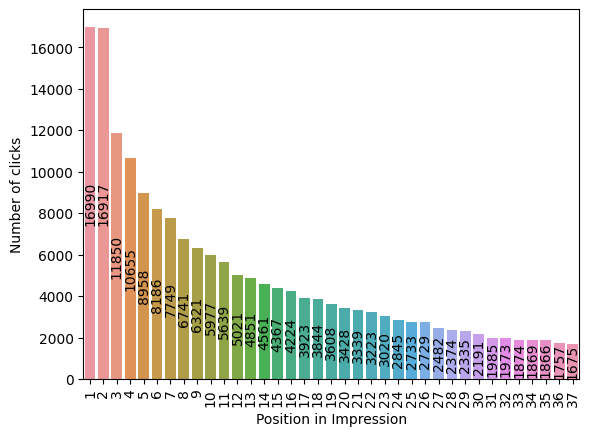

In [41]:

plt.rcParams['text.usetex'] = False
keys_nocfp = list(num_of_candidates_for_pos.keys())[:int(avg_impression_size)]
# get values in the same order as keys, and parse percentage values
vals_nocfp = list(num_of_candidates_for_pos.values())[:int(avg_impression_size)]

# Initialize bar plot
bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=vals_nocfp)

plt.xlabel("Position in Impression")
plt.ylabel("Number of clicks")
plt.bar_label(bars.containers[0],rotation=90,label_type="center")
plt.xticks([i for i in range(len(keys_nocfp))],rotation=90)

plt.savefig('pos_bias_linear.pdf',format='pdf',bbox_inches = "tight")
plt.show()

In [12]:
np.min(impression_sizes)

2

In [43]:
# This function is a free intuition of relevance due to more items
def exponetial_decay(x):
    return 1 - np.exp(-(1/15)*(x+6))

Exponential Decay

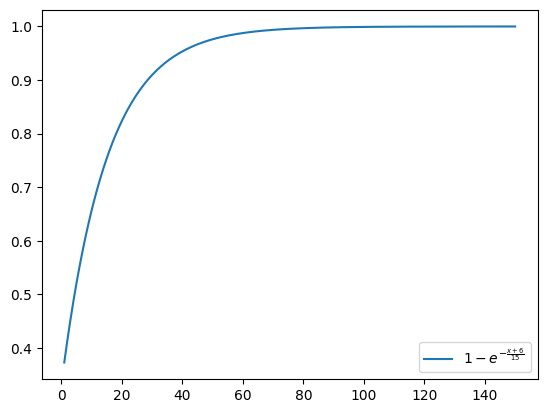

In [45]:
plt.rcParams['text.usetex'] = False

x = [i+1 for i in range(150)]
y = [exponetial_decay(i) for i in x]
sb.lineplot(x=x,y=y,label=r"$1 - e^{-\frac{x+6}{15}}$")

plt.legend(loc="lower right")

plt.savefig('exponential_decay.pdf',format='pdf',bbox_inches = "tight")
plt.show()

Histogram: Number of clicks per position using exponential decay

In [46]:
# Modified 
num_of_candidates_for_pos_decay = {}
for imp in small_train_behaviors['Impressions']: # Note that impressions are in the form of "imprID_1-0 imprID_2-1 imprID_3-0 ..."
    counter = []
    splitted = imp.split(' ')
    for pos,s in enumerate(splitted):
        if s.split('-')[1] == '1':  
            if (pos+1) in num_of_candidates_for_pos_decay.keys():
                num_of_candidates_for_pos_decay[(pos+1)] += exponetial_decay(len(splitted))
            else:
                num_of_candidates_for_pos_decay[(pos+1)] = exponetial_decay(len(splitted))


# Result dict with positions as keys and count as values (here: sorted used Code from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value )
num_of_candidates_for_pos_decay = {k: v for k, v in sorted(num_of_candidates_for_pos_decay.items(), key=lambda item: item[1],reverse=True)}

Histogram: Number of clicks per position

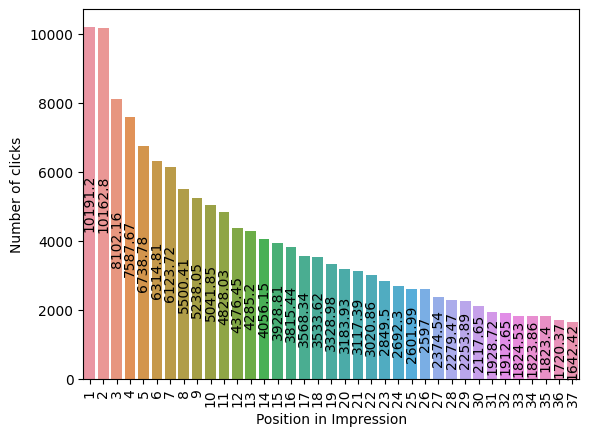

In [47]:
keys_nocfp = list(num_of_candidates_for_pos_decay.keys())[:int(avg_impression_size)]
# get values in the same order as keys, and parse percentage values
vals_nocfp = list(num_of_candidates_for_pos_decay.values())[:int(avg_impression_size)]

# Initialize bar plot
bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=vals_nocfp)

plt.xlabel("Position in Impression")
plt.ylabel("Number of clicks")
plt.bar_label(bars.containers[0],rotation=90,label_type="center")
plt.xticks([i for i in range(len(keys_nocfp))],rotation=90)

plt.savefig('decay_pos_bias.pdf',format='pdf',bbox_inches = "tight")
plt.show()

In [44]:
decay_mean = np.mean(list(num_of_candidates_for_pos_decay.values()))
decay_mean

726.2991551551136

Validate that the distribution is not uniformly (even if clearly visible)

In [59]:
scipy.stats.kstest(list(num_of_candidates_for_pos_decay.values()),'uniform',args=(0,len(num_of_candidates_for_pos_decay)))

KstestResult(statistic=0.35144927536231885, pvalue=5.481073821011087e-31)

In [66]:
tests_ks = []
for k,v in num_of_candidates_for_pos.items():
    tests_ks.extend([k] * v)

In [69]:
scipy.stats.kstest(tests_ks,'uniform',args=(0,len(num_of_candidates_for_pos_decay)))

KstestResult(statistic=0.6717666604303362, pvalue=0.0)

Histogram: Number of clicks per position

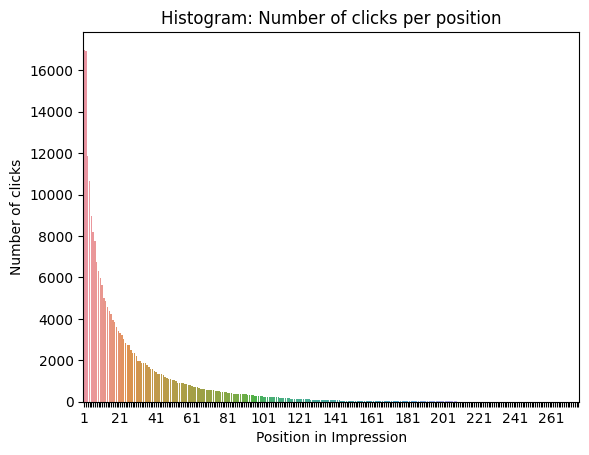

In [60]:
keys_nocfp = list(num_of_candidates_for_pos.keys())
# get values in the same order as keys, and parse percentage values
vals_nocfp = list(num_of_candidates_for_pos.values())

# Initialize bar plot
bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=vals_nocfp)

plt.title("Histogram: Number of clicks per position")
plt.xlabel("Position in Impression")
plt.ylabel("Number of clicks")


[l.set_visible(False) for (i,l) in enumerate(bars.xaxis.get_ticklabels()) if i % 20 != 0]

plt.savefig('positional_bias_all.pdf',format='pdf',bbox_inches = "tight")
plt.show()

Histogram: Number of clicks per position

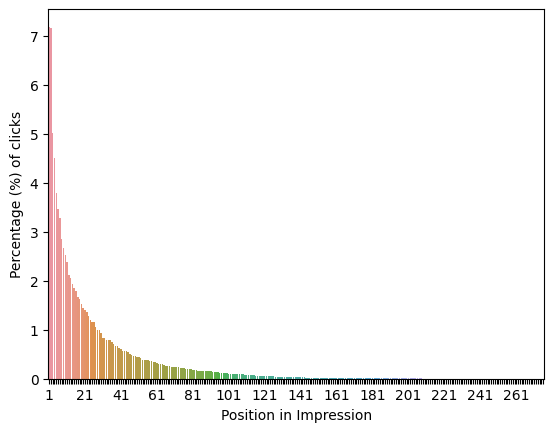

In [61]:
keys_nocfp = list(num_of_candidates_for_pos.keys())
# get values in the same order as keys, and parse percentage values
vals_nocfp = list(num_of_candidates_for_pos.values())

sum_of_clicks = np.sum(vals_nocfp)

relative_vals = [(i/sum_of_clicks)*100 for i in vals_nocfp]

# Initialize bar plot
bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=relative_vals)


plt.xlabel("Position in Impression")
plt.ylabel("Percentage (%) of clicks")


[l.set_visible(False) for (i,l) in enumerate(bars.xaxis.get_ticklabels()) if i % 20 != 0]

plt.savefig('positional_bias_all.pdf',format='pdf',bbox_inches = "tight")

plt.show()

The tendency towards lower positions is clear. However, for a fair view the position should be relative to the total number of the impressions. As an extreme example: If the total number is 1 than it is obvious that people choose the first item.</br>
To deal with this issue, I exclude impressions with less than 5 items.

Histogram: Number of clicks per position w/o small impressions

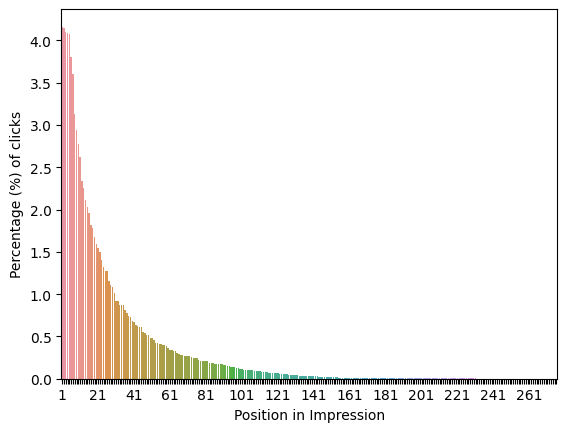

In [62]:
num_of_candidates_for_pos = {}
for imp in small_train_behaviors['Impressions']: # Note that impressions are in the form of "imprID_1-0 imprID_2-1 imprID_3-0 ..."
    if len(imp.split(' ')) > 4:
        counter = []
        for pos,s in enumerate(imp.split(' ')):
            if s.split('-')[1] == '1':  
                if (pos+1) in num_of_candidates_for_pos.keys():
                    num_of_candidates_for_pos[(pos+1)] += 1
                else:
                    num_of_candidates_for_pos[(pos+1)] = 1


# Result dict with positions as keys and count as values (here: sorted used Code from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value )
num_of_candidates_for_pos = {k: v for k, v in sorted(num_of_candidates_for_pos.items(), key=lambda item: item[1],reverse=True)}


keys_nocfp = list(num_of_candidates_for_pos.keys())
# get values in the same order as keys, and parse percentage values
vals_nocfp = list(num_of_candidates_for_pos.values())

sum_of_clicks = np.sum(vals_nocfp)

relative_vals = [(i/sum_of_clicks)*100 for i in vals_nocfp]

# Initialize bar plot
bars = sb.barplot(x=[i+1 for i in range(len(keys_nocfp))],y=relative_vals)

plt.xlabel("Position in Impression")
plt.ylabel("Percentage (%) of clicks")


[l.set_visible(False) for (i,l) in enumerate(bars.xaxis.get_ticklabels()) if i % 20 != 0]

plt.savefig('positional_bias_shrinked.pdf',format='pdf',bbox_inches = "tight")
plt.show()

In [13]:
from scipy.stats import skew

print(skew(vals_nocfp))

print(skew(vals_nocfp,bias=False))

3.2059316777154154
3.2234770898264564


**Prove of hypothesis:** The visualization above shows that with decreasing rank the items are less clicked. This is due to selection/positional bias.

## Exposure Bias

Exposure bias is the ambiguity of unseen versus not liked items. In MIND and other implicit feedback systems that means that some items would be clicked by the user but he just did not see them. It is closely related to the positional bias.


An exposure is unbiased if $P(\text{User u seen Item i}) = \frac{1}{|I|}$ for every Item $i \in  I$ and I is the Impression.

## Sentiment bias

In "*Towards analysing the bias of NRS using sentiment and stance detection*" sentiment bias is measured. It is shown that there is a slightly negativity in the sentiment of user preferences.<br />
Here, we want to take a look at the overall sentiment in the user behaviors of MIND. There we take a pretrained BERT model from [HuggingFace](https://huggingface.co/) to classify the sentiment of a title.

To classify a sentiment for each news, I uses a the BERT pipeline with a [finetuned Destilbert](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english). (See Code in bias_utils.py : create_sentiments_in_news())

In [64]:
# Load sentiments for training data
with open('Snapshots/dict_behaviors_impressions_sentiments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [65]:
sentiment_results = pd.DataFrame(loaded_dict)
sentiment_results = sentiment_results.T

In [66]:
# These results are the averaged sentiments for behaviors and impressions
sentiment_results.head()

,Behaviors,Impressions
U100,-0.400000,-0.104762
U1000,0.333333,0.021694
U10001,-0.333333,-0.184211
U10003,-0.250000,-0.157287
U10008,-0.130435,-0.194444


In [67]:
path_sentimented_news = "Dataset_small/train/test_with_sentiment.tsv"
sentimented_news = pd.read_csv(path_sentimented_news,sep="\t",index_col=0)

There are three different interesting measures.<br />
1. Overall news sentiment distribution (how much of total news are positive/negative)
2. Potential user bias to pick more positive/negative news titles.
3. Overall sentiment in the proposed impression in MIND
4. Overall deviation from user behavior sentiment to its impression


### Overall news sentiment

Number of positive and negative sentiments

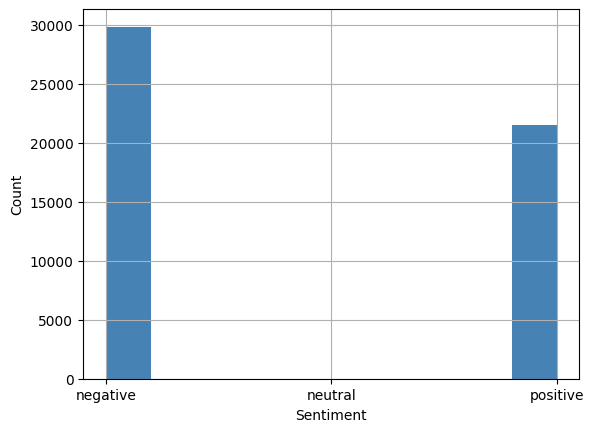

Positive sentiments: 21457/51281 (41.84%)
Negative sentiments: 29824/51281 (58.16%)
There are about 1.39 more negative than positive sentiments in the training data.
The average sentiment is -0.1631598447768179


In [73]:
import matplotlib.pyplot as plt
# Overall news sentiment distribution (how much of total news are positive/negative)
sentimented_news['Sentiment'].hist(color='steelblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.xticks([-1,0,1],['negative','neutral','positive'])

plt.savefig('sentiment_overall.pdf',format='pdf',bbox_inches = "tight")
plt.show()

num_pos = len(sentimented_news[sentimented_news['Sentiment']== 1])
num_neg = len(sentimented_news[sentimented_news['Sentiment']== -1])
num_total = len(sentimented_news)
print(f'Positive sentiments: {num_pos}/{num_total} ({round(100*(num_pos/num_total),2)}%)\nNegative sentiments: {num_neg}/{num_total} ({round(100*(num_neg/num_total),2)}%)')
print(f'There are about {round(num_neg/num_pos,3)} more negative than positive sentiments in the training data.')
print(f'The average sentiment is {(num_pos - num_neg) / num_total}')

### Potential user sentiment bias

To see a user sentiment bias we take a look at the average behaviors/history of users

Number of average sentiments in the history

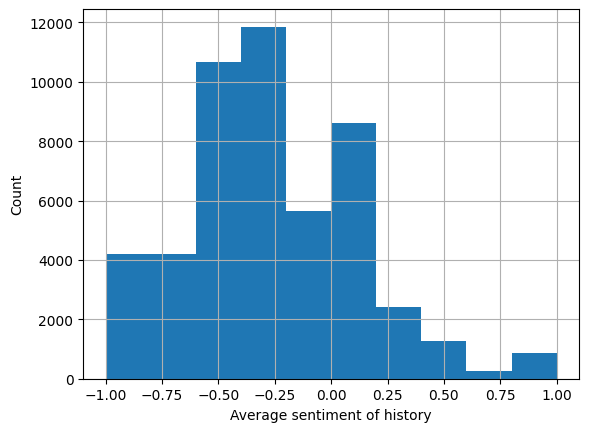

Average positive sentiments: 8565/50000 (17.13%)
Average negative sentiments: 36573/50000 (73.15%)
There are about 4.27 more average negative than average positive sentiments in the training data.
The statistics of average user sentiment are
count    50000.000000
mean        -0.271557
std          0.397828
min         -1.000000
25%         -0.500000
50%         -0.300000
75%          0.000000
max          1.000000
Name: Behaviors, dtype: float64


In [74]:
sentiment_results['Behaviors'].hist()
plt.xlabel('Average sentiment of history')
plt.ylabel('Count')

plt.savefig('history_sentiments.pdf',format='pdf',bbox_inches = "tight")

plt.show()

num_pos = len(sentiment_results[sentiment_results['Behaviors'] > 0])
num_neg = len(sentiment_results[sentiment_results['Behaviors'] < 0])
num_neu = len(sentiment_results[sentiment_results['Behaviors'] == 0])
num_total = len(sentiment_results)

stats = sentiment_results['Behaviors'].describe()
print(f'Average positive sentiments: {num_pos}/{num_total} ({round(100*(num_pos/num_total),2)}%)\nAverage negative sentiments: {num_neg}/{num_total} ({round(100*(num_neg/num_total),2)}%)')
print(f'There are about {round(num_neg/num_pos,3)} more average negative than average positive sentiments in the training data.')
print(f'The statistics of average user sentiment are\n{stats}')

Note that there are much more negative than positive sentiments in comparison to the overall news sentiment.

### Average sentiment in impressions

Number of average sentiments in the impressions

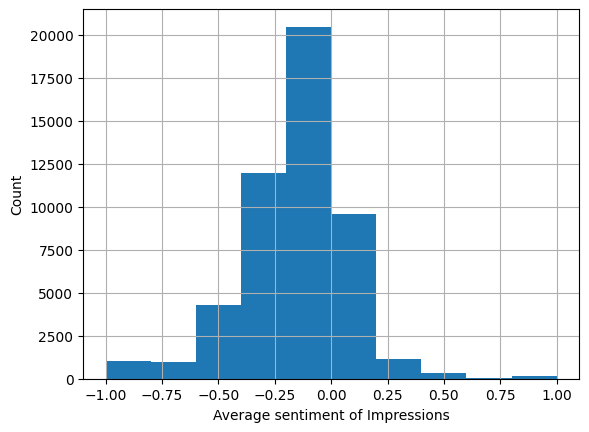

Average positive sentiments: 9063/50000 (18.13%)
Average negative sentiments: 38725/50000 (77.45%)
There are about 4.273 more average negative than average positive sentiments in the training data.
The statistics of average user sentiment are
count    50000.000000
mean        -0.159119
std          0.240844
min         -1.000000
25%         -0.266667
50%         -0.136201
75%         -0.018298
max          1.000000
Name: Impressions, dtype: float64


In [75]:
sentiment_results['Impressions'].hist()
plt.xlabel('Average sentiment of Impressions')
plt.ylabel('Count')

plt.savefig('impression_sentiments.pdf',format='pdf',bbox_inches = "tight")

plt.show()

num_pos = len(sentiment_results[sentiment_results['Impressions'] > 0])
num_neg = len(sentiment_results[sentiment_results['Impressions'] < 0])
num_neu = len(sentiment_results[sentiment_results['Impressions'] == 0])
num_total = len(sentiment_results)

stats = sentiment_results['Impressions'].describe()
print(f'Average positive sentiments: {num_pos}/{num_total} ({round(100*(num_pos/num_total),2)}%)\nAverage negative sentiments: {num_neg}/{num_total} ({round(100*(num_neg/num_total),2)}%)')
print(f'There are about {round(num_neg/num_pos,3)} more average negative than average positive sentiments in the training data.')
print(f'The statistics of average user sentiment are\n{stats}')

### Average deviation from behavior to impression

Number of absolute deviations

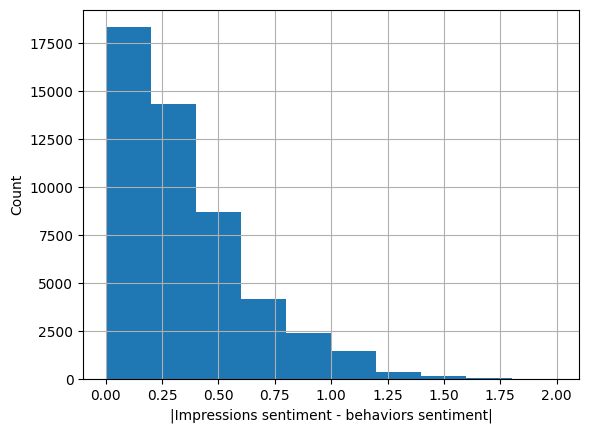

In [76]:

np.abs(sentiment_results['Behaviors'] - sentiment_results['Impressions']).hist()
plt.xlabel('|Impressions sentiment - behaviors sentiment|')
plt.ylabel('Count')
plt.savefig('absolute_deviation_sentiment.pdf',format='pdf',bbox_inches = "tight")

diff_neg = len(sentiment_results.query('Impressions < 0 and Behaviors < 0'))
diff_pos = len(sentiment_results.query('Impressions >= 0 and Behaviors >= 0'))
diff_neu = len(sentiment_results) - diff_pos - diff_neg

plt.show()


In [77]:
# Deviation between [2, -2] -> positive means behaviors are slightly more positive / negative means behaviors more negative
sentiment_results['Deviation'] = sentiment_results.apply(lambda row : row['Behaviors'] - row['Impressions'],axis=1)


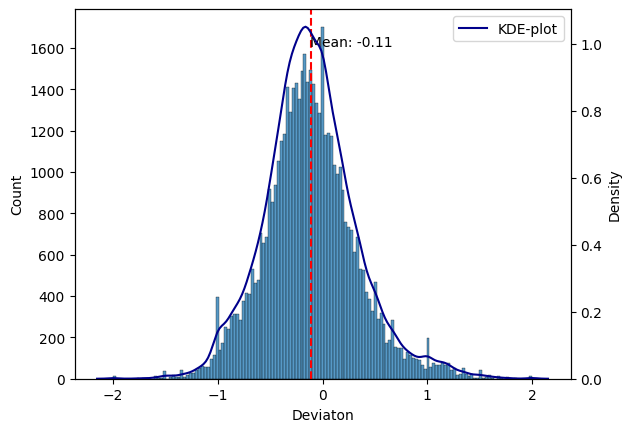

In [78]:
from scipy.stats import norm

dev_mean  = np.mean(sentiment_results['Deviation'])

fig, ax_left = plt.subplots()

# Histogram
sb.histplot(sentiment_results['Deviation'],ax=ax_left,label ="Histogram")
ax_left.set_xlabel("Deviaton")


# Mean with text on it is modified by https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
ax_left.axvline(dev_mean,color="red", linestyle='dashed', linewidth=1.5)
_, max_ylim = ax_left.get_ylim()
ax_left.text(dev_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(dev_mean))
ax2= ax_left.twinx()

# KDE plot
sb.kdeplot(sentiment_results['Deviation'],color="darkblue",ax=ax2,label="KDE-plot")
ax2.legend(loc="upper right")

plt.savefig('KDE_hist_deviation.pdf',format='pdf',bbox_inches = "tight")

plt.show()

count    50000.000000
mean        -0.112438
std          0.444458
min         -2.000000
25%         -0.384444
50%         -0.133333
75%          0.134389
max          2.000000
Name: Deviation, dtype: float64


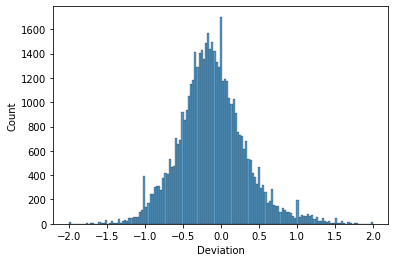

In [15]:
sb.histplot(sentiment_results['Deviation'])
print(sentiment_results['Deviation'].describe())

Number of negative/negative results: 29077 (58.15%)
Number of positive/positive results: 3779 (7.56%)
Number of different results: 17144 (34.29%)


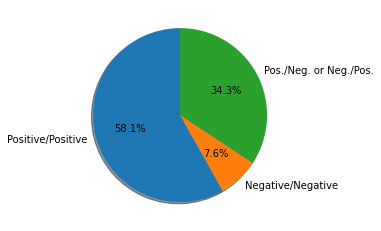

In [15]:
print(f"Number of negative/negative results: {diff_neg} ({round(100*diff_neg/len(sentiment_results),2)}%)")
print(f"Number of positive/positive results: {diff_pos} ({round(100*diff_pos/len(sentiment_results),2)}%)")
print(f"Number of different results: {len(sentiment_results) - diff_neg - diff_pos} ({round(100*(len(sentiment_results) - diff_neg - diff_pos)/len(sentiment_results),2)}%)")

plt.pie([round(100*diff_neg/len(sentiment_results),2),round(100*diff_pos/len(sentiment_results),2),round(100*diff_neu/len(sentiment_results),2)],labels=['Positive/Positive','Negative/Negative','Pos./Neg. or Neg./Pos.'],autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.show()

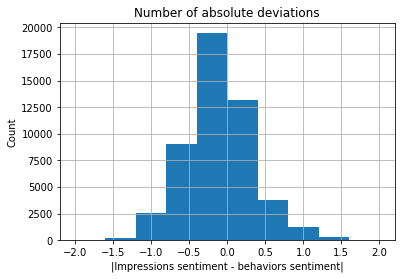

Number of negative/negative results: 29077 (58.15%)
Number of positive/positive results: 3779 (7.56%)
Number of different results: 17144 (34.29%)


In [9]:

(sentiment_results['Behaviors'] - sentiment_results['Impressions']).hist()
plt.xlabel('|Impressions sentiment - behaviors sentiment|')
plt.ylabel('Count')
plt.title('Number of absolute deviations')

plt.show()

diff_neg = len(sentiment_results.query('Impressions < 0 and Behaviors < 0'))
diff_pos = len(sentiment_results.query('Impressions >= 0 and Behaviors >= 0'))
print(f"Number of negative/negative results: {diff_neg} ({round(100*diff_neg/len(sentiment_results),2)}%)")
print(f"Number of positive/positive results: {diff_pos} ({round(100*diff_pos/len(sentiment_results),2)}%)")
print(f"Number of different results: {len(sentiment_results) - diff_neg - diff_pos} ({round(100*(len(sentiment_results) - diff_neg - diff_pos)/len(sentiment_results),2)}%)")



This indicates that there is no real consideration in sentimental information in the models

# Investigating model biases
Since this biases are model-based I use a trained model to evaluate the biases.

## Recency matters

By Research of Ji, Yiton et al.[1] active users get better recommendations than the inactive ones. 

[1] Ji, Yitong et al. “Do Loyal Users Enjoy Better Recommendations?: Understanding Recommender Accuracy from a Time Perspective.” Proceedings of the 2022 ACM SIGIR International Conference on Theory of Information Retrieval (2022): n. pag.

To quantify this results, I test the performance of active users with the performance of inactive users.<br />
Following the definitions of Ji, Yiton et al. 

_Recency_ describes the time between the last interaction of a user with the recommender system. An _active_ user has his/her last interaction in the top most recent 50% of interactions.

**Kann entfernt werden da Historieneinträge nicht zeitlich festgehalten sind --> keine Zeiterfassung der letzten interaktion möglich**

In [12]:
path_test_behaviors_small = "Dataset_small/test/behaviors.tsv"


small_test_behaviors = pd.read_csv(path_test_behaviors_small,delimiter='\t',index_col=False)
small_test_behaviors.columns = cols_behaviors


path_test_news_small = "Dataset_small/test/news.tsv"


smal_test_news = pd.read_csv(path_test_news_small,delimiter='\t',index_col=False)
smal_test_news.columns = cols_news

In [6]:
# Calculate the border time of active and inactive users

# Find distinct users with latest impression time
grouped_users = small_test_behaviors.groupby(['User ID'])

users_only_latest_interactions = grouped_users['Time'].max() # latest time for each user
users_only_latest_interactions = users_only_latest_interactions.sort_values() # Sorted values 


In [7]:
# The value in the middle of the dataframe is the border
print(users_only_latest_interactions.iloc[int(len(users_only_latest_interactions)/2)])

# Earliest interaction and latest interaction
print(users_only_latest_interactions.iloc[int(len(users_only_latest_interactions) - 1)])
print(users_only_latest_interactions.iloc[0])

11/15/2019 5:35:06 AM
11/15/2019 9:59:59 PM
11/15/2019 10:00:00 AM


--> The times are to close together that recency doesnt matter

In [28]:
small_test_behaviors[small_test_behaviors.duplicated(subset=['User ID'],keep=False)].sort_values(['User ID'])

,Impression ID,User ID,Time,History,Impressions
51629,51631,U100,11/15/2019 12:20:27 PM,N99587 N61339 N129790 N12721 N100405 N103530 N...,N18468-1 N89764-0 N21018-0 N129416-1 N46641-0 ...
25116,25118,U100,11/15/2019 5:13:06 AM,N99587 N61339 N129790 N12721 N100405 N103530 N...,N122944-0 N55801-0 N104644-0 N82503-0 N29160-0...
30992,30994,U100050,11/15/2019 7:53:46 AM,N43502 N78650 N18389 N89872 N119800 N102743 N6...,N62800-0 N122944-1 N48833-0 N17106-0 N122640-0...
44026,44028,U100050,11/15/2019 1:07:30 PM,N43502 N78650 N18389 N89872 N119800 N102743 N6...,N85420-0 N121267-0 N123209-0 N89764-0 N30206-0...
2043,2045,U100050,11/15/2019 12:09:13 PM,N43502 N78650 N18389 N89872 N119800 N102743 N6...,N89764-0 N18468-0 N56602-1 N29160-0 N30206-0 N...
...,...,...,...,...,...
42781,42783,U999,11/15/2019 2:41:47 PM,N122772 N32720 N35797 N122047 N110755 N59820 N...,N129503-0 N33378-0 N27339-0 N29160-0 N115923-0...
993,995,U999,11/15/2019 10:52:52 AM,N122772 N32720 N35797 N122047 N110755 N59820 N...,N2110-1 N26703-0
5967,5969,U999,11/15/2019 4:39:38 AM,N122772 N32720 N35797 N122047 N110755 N59820 N...,N27034-0 N105034-0 N15125-0 N41089-0 N36918-0 ...
70674,70676,U99984,11/15/2019 12:35:32 PM,N121592 N127001,N69938-0 N58760-0 N100425-0 N48833-0 N123209-0...


In [16]:
smal_test_news['URL']

0         https://assets.msn.com/labs/mind/AABmf2I.html
1         https://assets.msn.com/labs/mind/AAB19MK.html
2         https://assets.msn.com/labs/mind/AAISxPN.html
3         https://assets.msn.com/labs/mind/AAJgNsz.html
4         https://assets.msn.com/labs/mind/AACk2N6.html
                              ...                      
169382    https://assets.msn.com/labs/mind/BBWsb2c.html
169383    https://assets.msn.com/labs/mind/BBWsbQg.html
169384    https://assets.msn.com/labs/mind/BBWscU8.html
169385    https://assets.msn.com/labs/mind/BBWscWw.html
169386    https://assets.msn.com/labs/mind/BBzMpnG.html
Name: URL, Length: 169387, dtype: object

All users with interactions earlier than 11/15/2019 5:35:06 AM are therefore inactive users.

Now, I create a new test set one with active and one with inactive users.